## import hazard data and plot, check

In [3]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox

In [4]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [5]:
cd /home/op/network_manila

/home/op/network_manila


In [6]:
#import hazard data

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

In [7]:
liquefaction.crs, faultline.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

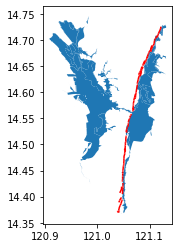

In [8]:
base=liquefaction.plot()
faultline.plot(ax=base, color='red')

In [9]:
#buffer around faultline (50 meters)

faultline["geometry_buffer50"] = faultline.geometry
faultline = faultline.set_geometry("geometry_buffer50")
faultline = faultline.to_crs(crs_manila)
faultline["geometry_buffer50"] = faultline.geometry.buffer(50)
faultline = faultline.to_crs(crs_global)


In [10]:
#import asset data

schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")

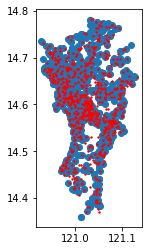

In [11]:
base=schools.plot()
hospitals.plot(ax=base, color='red', markersize=2)

In [12]:
len(schools), len(hospitals), schools.crs, hospitals.crs

(768, 734, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [13]:
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )

NameError: name 'G' is not defined

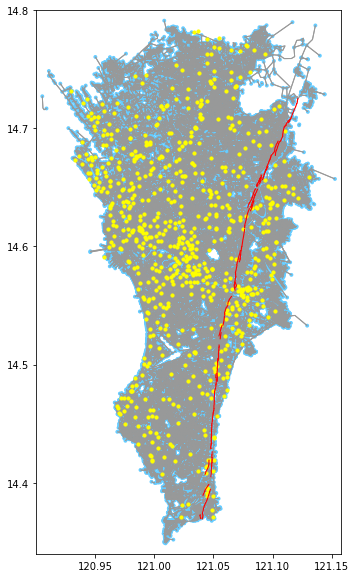

<Figure size 432x288 with 0 Axes>

In [164]:
fig, ax = ox.plot_graph(G, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red', zorder=3)
hospitals.plot(ax=ax, color='yellow', markersize=10, zorder=2)
fig

## disrupt network with hazard data

In [14]:
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point


In [15]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [16]:
def tag_nodes_intersecting_gdf(G, gdf, property_name = 'intersects_gdf'):
    """
    this function tags each node of the graph which lies within the passed geodataframe's polygon
    note that graph and gdf must be in the same crs!
    :param G: a graph containing one or more nodes
    :param gdf: a geodataframe
    :param property_name: a property name for whether the node intersects the gdf
    :returns: a graph
    """

    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G_copy.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe!')

    # create list of values, throw out nodes that don't intersect the gdf
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(gdf_geometry):
            selPts.append(1)
            selKeys.append(key)

    # generate new dictionary of {node ID: 1 where 1 signals intersection}
    ref = dict(zip(selKeys, selPts))

    # load new values onto node data dictionary, set to 0 if not intersecting
    missedCnt = 0
    for u, data in G_copy.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            data[property_name] = 0
            missedCnt += 1
    print("Number of original nodes:", len(G_copy.nodes))
    print("Number of missed nodes gdf:", missedCnt)
    print("Number of nodes that intersect gdf:", len(selKeys))

    return G_copy

In [17]:
G_liq = tag_nodes_intersecting_gdf(G_clip, liquefaction, property_name = 'intersects_liquefaction')

Number of original nodes: 4075
Number of missed nodes gdf: 2557
Number of nodes that intersect gdf: 1518


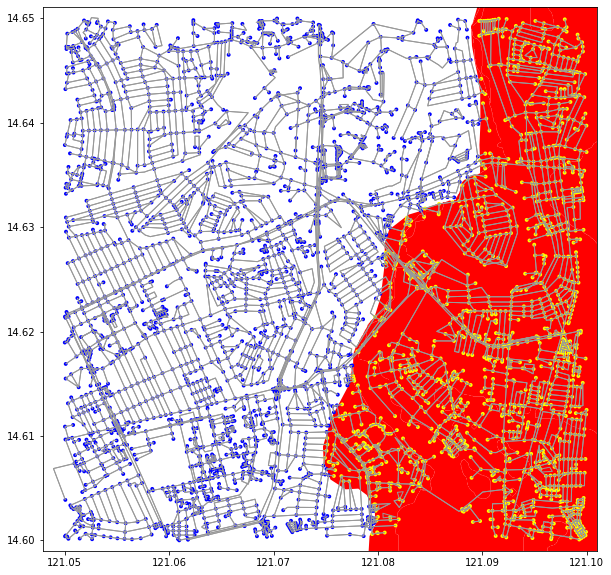

<Figure size 432x288 with 0 Axes>

In [18]:
G_liq.graph.update( {'crs' : crs_global} )
G_liq.graph.update( {'name' : 'manila'} )
nc = ['yellow' if data['intersects_liquefaction']==1 else 'blue' for u, data in G_liq.nodes(data=True)]
fig, ax = ox.plot_graph(G_liq, fig_height=10, axis_off=False, show=False, node_color=nc)
liquefaction.plot(ax=ax, color='red', zorder=0)
fig

In [23]:
def remove_edges_intersecting_polygons(G, polygons, mode,crs = None, fast = False):
    """
    Function for removing edges of a graph that intersect polygon(s).
    Ensure any GeoDataFrames are in the same projection before using function, or pass a crs.
    Wrapper function around gn.grah_edges_intersecting_polygons


    :param G: a Graph object
    :param polygons: a GeoDataFrame containing one or more polygons
    :param mode: a string, either 'contains' or 'intersects'
    :param crs: If passed, will reproject both polygons and graph edge gdf to this projection.
    :param fast: (default: True): we can cheaply test whether an edge intersects a polygon gdf by checking whether either the start or end nodes are within a polygon. If both are, then we return 'contained'; if at least one is, we can return 'intersects'. If we set fast to False, then we iterate through each geometry one at a time, and check to see whether the geometry object literally intersects the polygon geodataframe, one at a time. May be computationally intensive!
    :returns: the graph with edges intersecting polygons as well as isolated nodes removed
    """
    
    G_copy = G.copy()
    
    #identify and remove nodes intersecting polygons
    nodes_gdf = gn.graph_edges_intersecting_polygon(G_clip, polygons = polygons, mode = mode,
                                               crs = crs, fast = fast) 
    edges_to_remove = list(zip(nodes_gdf['stnode'], nodes_gdf['endnode']))
    G_copy.remove_edges_from(edges_to_remove)

    
    #remove isolated nodes that are no longer connected to any edges
    outdeg = G_copy.out_degree()
    nodes_to_remove = [n for (n, deg) in outdeg if deg == 0]
    G_copy.remove_nodes_from(nodes_to_remove)
    
    return G_copy


In [24]:
G_faultline = remove_edges_intersecting_polygons(G_liq, polygons = faultline, mode = "intersects",
                                               crs = None, fast = False)

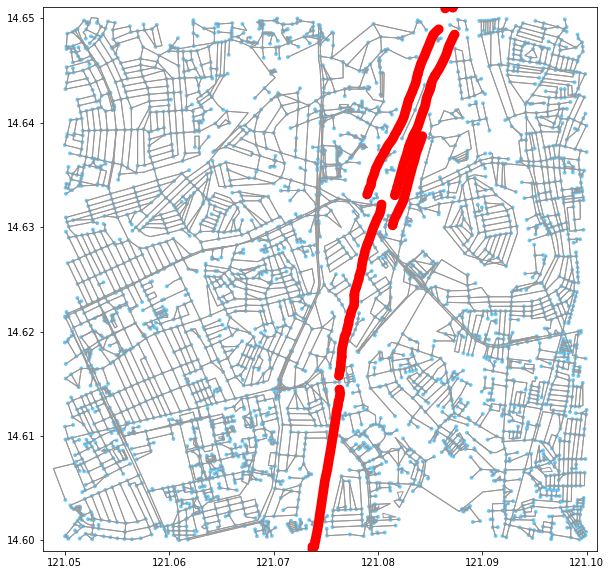

<Figure size 432x288 with 0 Axes>

In [25]:
fig, ax = ox.plot_graph(G_faultline, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red')
fig

In [29]:
G_disrupt = gn.disrupt_network(G_faultline, "intersects_liquefaction", 0.5, 4.5)

nodes disrupted: 1501
edges disrupted: 4044


In [32]:
gn.save(G_disrupt,'manila_clean_clipped_disrupted','data_osm_raw')

disruption in GN is working based on whether nodes are in field of disaster -
this is bad if long edges without nodes lead through disaster fields, as these will not be affected. 
one solution to this is the salt long lines option


for ground liquefaction we want to slow everything down - could use approach similar to this: 
    https://github.com/worldbank/GOST_PublicGoods/blob/master/Implementations/SierraLeone%20-%20GOSTnets/Step%204.a%20-%20Generate%20Flooding%20Version%20of%20Graph.ipynb

In [ ]:

def disrupt_network(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against a node's value. 
    Any edges which bind to broken nodes have their 'time' property set to fail_value


## od matrices

In [ ]:
project graph
convert to time

In [39]:
gn.example_node(G)

(0, {'x': 121.032836, 'y': 14.566063})


In [40]:
gn.example_edge(G)

(0, 19650, {'Wkt': 'LINESTRING (121.032836 14.566063, 121.033509 14.5655514)', 'id': 18962, 'infra_type': 'residential', 'osm_id': '23006710', 'key': 'edge_18962', 'length': 0.0920008330049905, 'Type': 'legitimate'})


In [ ]:
disruptio

gn bugs

- function graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True) specifies moode= 'intersecting' as param, but checks for 'intersects'

- function clip doesn't work because shapely isn't imported 
- function clip doesn't work with new networkx